TODO:
- update node simulations to make it so that each "timestep" is an epoch (360 blocks, with each block being 12 seconds)
- multiple audits can take place during an epoch


=== Reliable Node Then Failing ===
Audit 50: Score=1.0000, DQ=False
Audit 100: Score=1.0000, DQ=False
Audit 150: Score=1.0000, DQ=False
Audit 200: Score=1.0000, DQ=False
Audit 250: Score=1.0000, DQ=False
Audit 300: Score=1.0000, DQ=False
Audit 350: Score=1.0000, DQ=False
Audit 400: Score=1.0000, DQ=False
Audit 450: Score=1.0000, DQ=False
Audit 500: Score=1.0000, DQ=False
Audit 550: Score=1.0000, DQ=False
Audit 600: Score=1.0000, DQ=False
Audit 650: Score=1.0000, DQ=False
Audit 700: Score=1.0000, DQ=False
Audit 750: Score=1.0000, DQ=False
Audit 800: Score=1.0000, DQ=False
Audit 850: Score=1.0000, DQ=False
Audit 900: Score=1.0000, DQ=False
Audit 950: Score=1.0000, DQ=False
Audit 1000: Score=1.0000, DQ=False
Audit 1050: Score=1.0000, DQ=False
Audit 1100: Score=1.0000, DQ=False
Audit 1150: Score=1.0000, DQ=False
Audit 1200: Score=1.0000, DQ=False
Audit 1250: Score=1.0000, DQ=False
Audit 1300: Score=1.0000, DQ=False
Audit 1350: Score=1.0000, DQ=False
Audit 1400: Score=1.0000, DQ=False
Audi

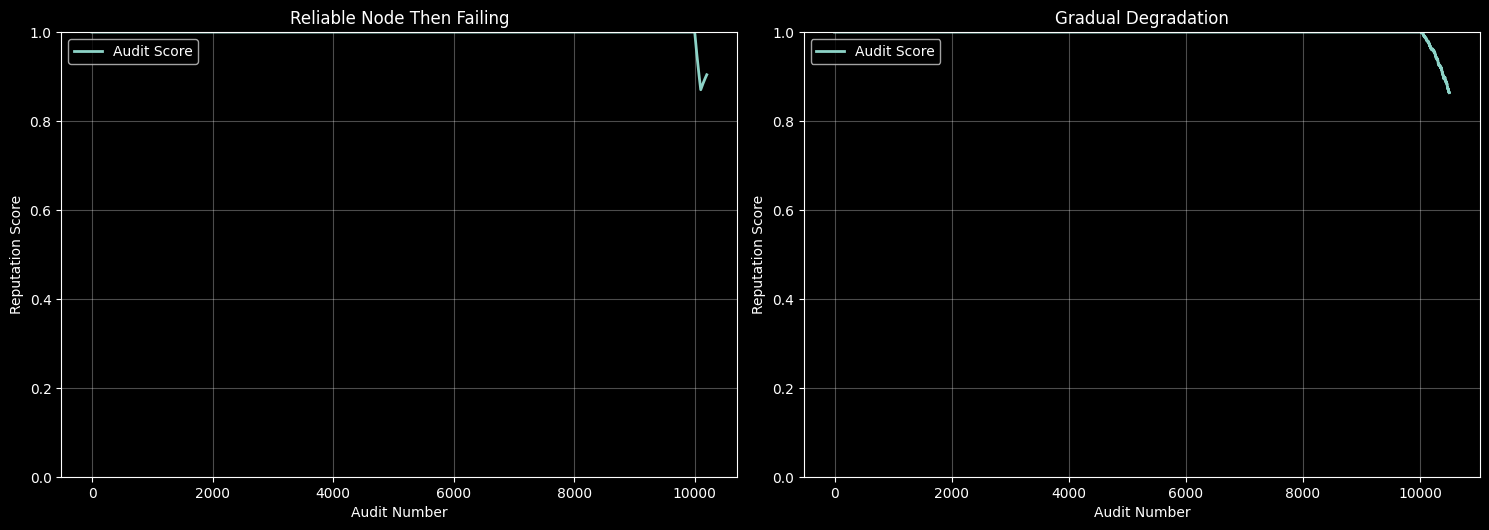

In [ ]:
import numpy as np  
import matplotlib.pyplot as plt

# by default make matplotlib use dark mode
plt.style.use('dark_background')
  
class NodeReputationSimulator:  
    def __init__(self):  
        # Configuration from satellite/reputation/config.go  
        self.audit_lambda = 0.997
        self.audit_weight = 1.0
        self.audit_dq = 0.96  
        self.initial_alpha = 1000.0  
        self.initial_beta = 0.0  
          
        # Initialize reputation  
        self.audit_alpha = self.initial_alpha  
        self.audit_beta = self.initial_beta  
          
        self.history = []  
          
    def update_reputation_multiple(self, beta, alpha, lambda_val, weight, success):  
        """Implementation of UpdateReputationMultiple from reputation package"""  
        v = 1.0 if success else 0.0
        alpha = lambda_val * alpha + weight*(1+v)/2
        beta = lambda_val * beta + weight*(1-v)/2
        return beta, alpha  
      
    def apply_audit_result(self, result_type):  
        """Apply audit results: 'success', 'failure', 'offline'"""  
        if result_type == 'failure':  
            self.audit_beta, self.audit_alpha = self.update_reputation_multiple(  
                self.audit_beta, self.audit_alpha, self.audit_lambda, self.audit_weight, False
            )  
        else:
            # Success improves reputation
            self.audit_beta, self.audit_alpha = self.update_reputation_multiple(  
                self.audit_beta, self.audit_alpha, self.audit_lambda, self.audit_weight, True  
            )  
          
        # Record current state  
        audit_score = self.audit_alpha / (self.audit_alpha + self.audit_beta)  
          
        self.history.append({  
            'audit_score': audit_score,  
            'audit_alpha': self.audit_alpha,  
            'audit_beta': self.audit_beta,  
            'disqualified': audit_score <= self.audit_dq
        })  
      
    def simulate_scenario(self, scenario_name, events):  
        """Simulate a sequence of audit events"""  
        # print(f"\n=== {scenario_name} ===")  
        self.__init__()  # Reset  
          
        for event in events:  
            self.apply_audit_result(event['type'])  
            if len(self.history) % 50 == 0:  # Print every 50 audits  
                last = self.history[-1]  
                # print(f"Audit {len(self.history)}: Score={last['audit_score']:.4f}, "  
                #       f"DQ={last['disqualified']}")  
          
        return self.history  
  
# Scenario 1: Reliable node that suddenly starts failing  
def scenario_reliable_then_failing():  
    events = []  
    # 500 successful audits (building good reputation)  
    events.extend([{'type': 'success'} for _ in range(10000)])  
    # Sudden failure period - 50 failures  
    events.extend([{'type': 'failure'} for _ in range(100)])  
    # Try to recover with successes  
    events.extend([{'type': 'success'} for _ in range(100)])  
    return events  
  
# Scenario 3: Gradual degradation  
def scenario_gradual_degradation():  
    events = []  
    # Start reliable  
    events.extend([{'type': 'success'} for _ in range(10000)])  
      
    # Gradually increase failure rate  
    for phase in range(10):  
        failure_rate = 0.05 + (phase * 0.05)  # 5% to 50% failure rate  
        for _ in range(50):  
            if np.random.random() < failure_rate:  
                events.append({'type': 'failure'})  
            else:  
                events.append({'type': 'success'})  
    return events  
  
# Run simulations  
simulator = NodeReputationSimulator()  
  
scenarios = [  
    ("Reliable Node Then Failing", scenario_reliable_then_failing()),  
    ("Gradual Degradation", scenario_gradual_degradation())  
]  
  
plt.figure(figsize=(15, 10))  
  
for i, (name, events) in enumerate(scenarios):  
    history = simulator.simulate_scenario(name, events)  
      
    plt.subplot(2, 2, i+1)  
    audit_scores = [h['audit_score'] for h in history]  
      
    plt.plot(audit_scores, label='Audit Score', linewidth=2)  
    # plt.axhline(y=0.96, color='red', linestyle='--', label='Audit DQ Threshold')  
      
    plt.title(name)  
    plt.xlabel('Audit Number')  
    plt.ylabel('Reputation Score')  
    plt.legend()  
    plt.grid(True, alpha=0.3)  
    plt.ylim(0, 1)
  
plt.tight_layout()  
plt.show()  
  
# Print final statistics  
# for name, events in scenarios:  
#     history = simulator.simulate_scenario(name, events)  
#     final = history[-1]  
#     dq_point = next((i for i, h in enumerate(history) if h['disqualified']), None)  
      
#     print(f"\n{name} Final Results:")  
#     print(f"  Final Audit Score: {final['audit_score']:.4f}")  
#     print(f"  Disqualified: {final['disqualified']}")  
#     if dq_point:  
#         print(f"  Disqualified at audit: {dq_point + 1}")

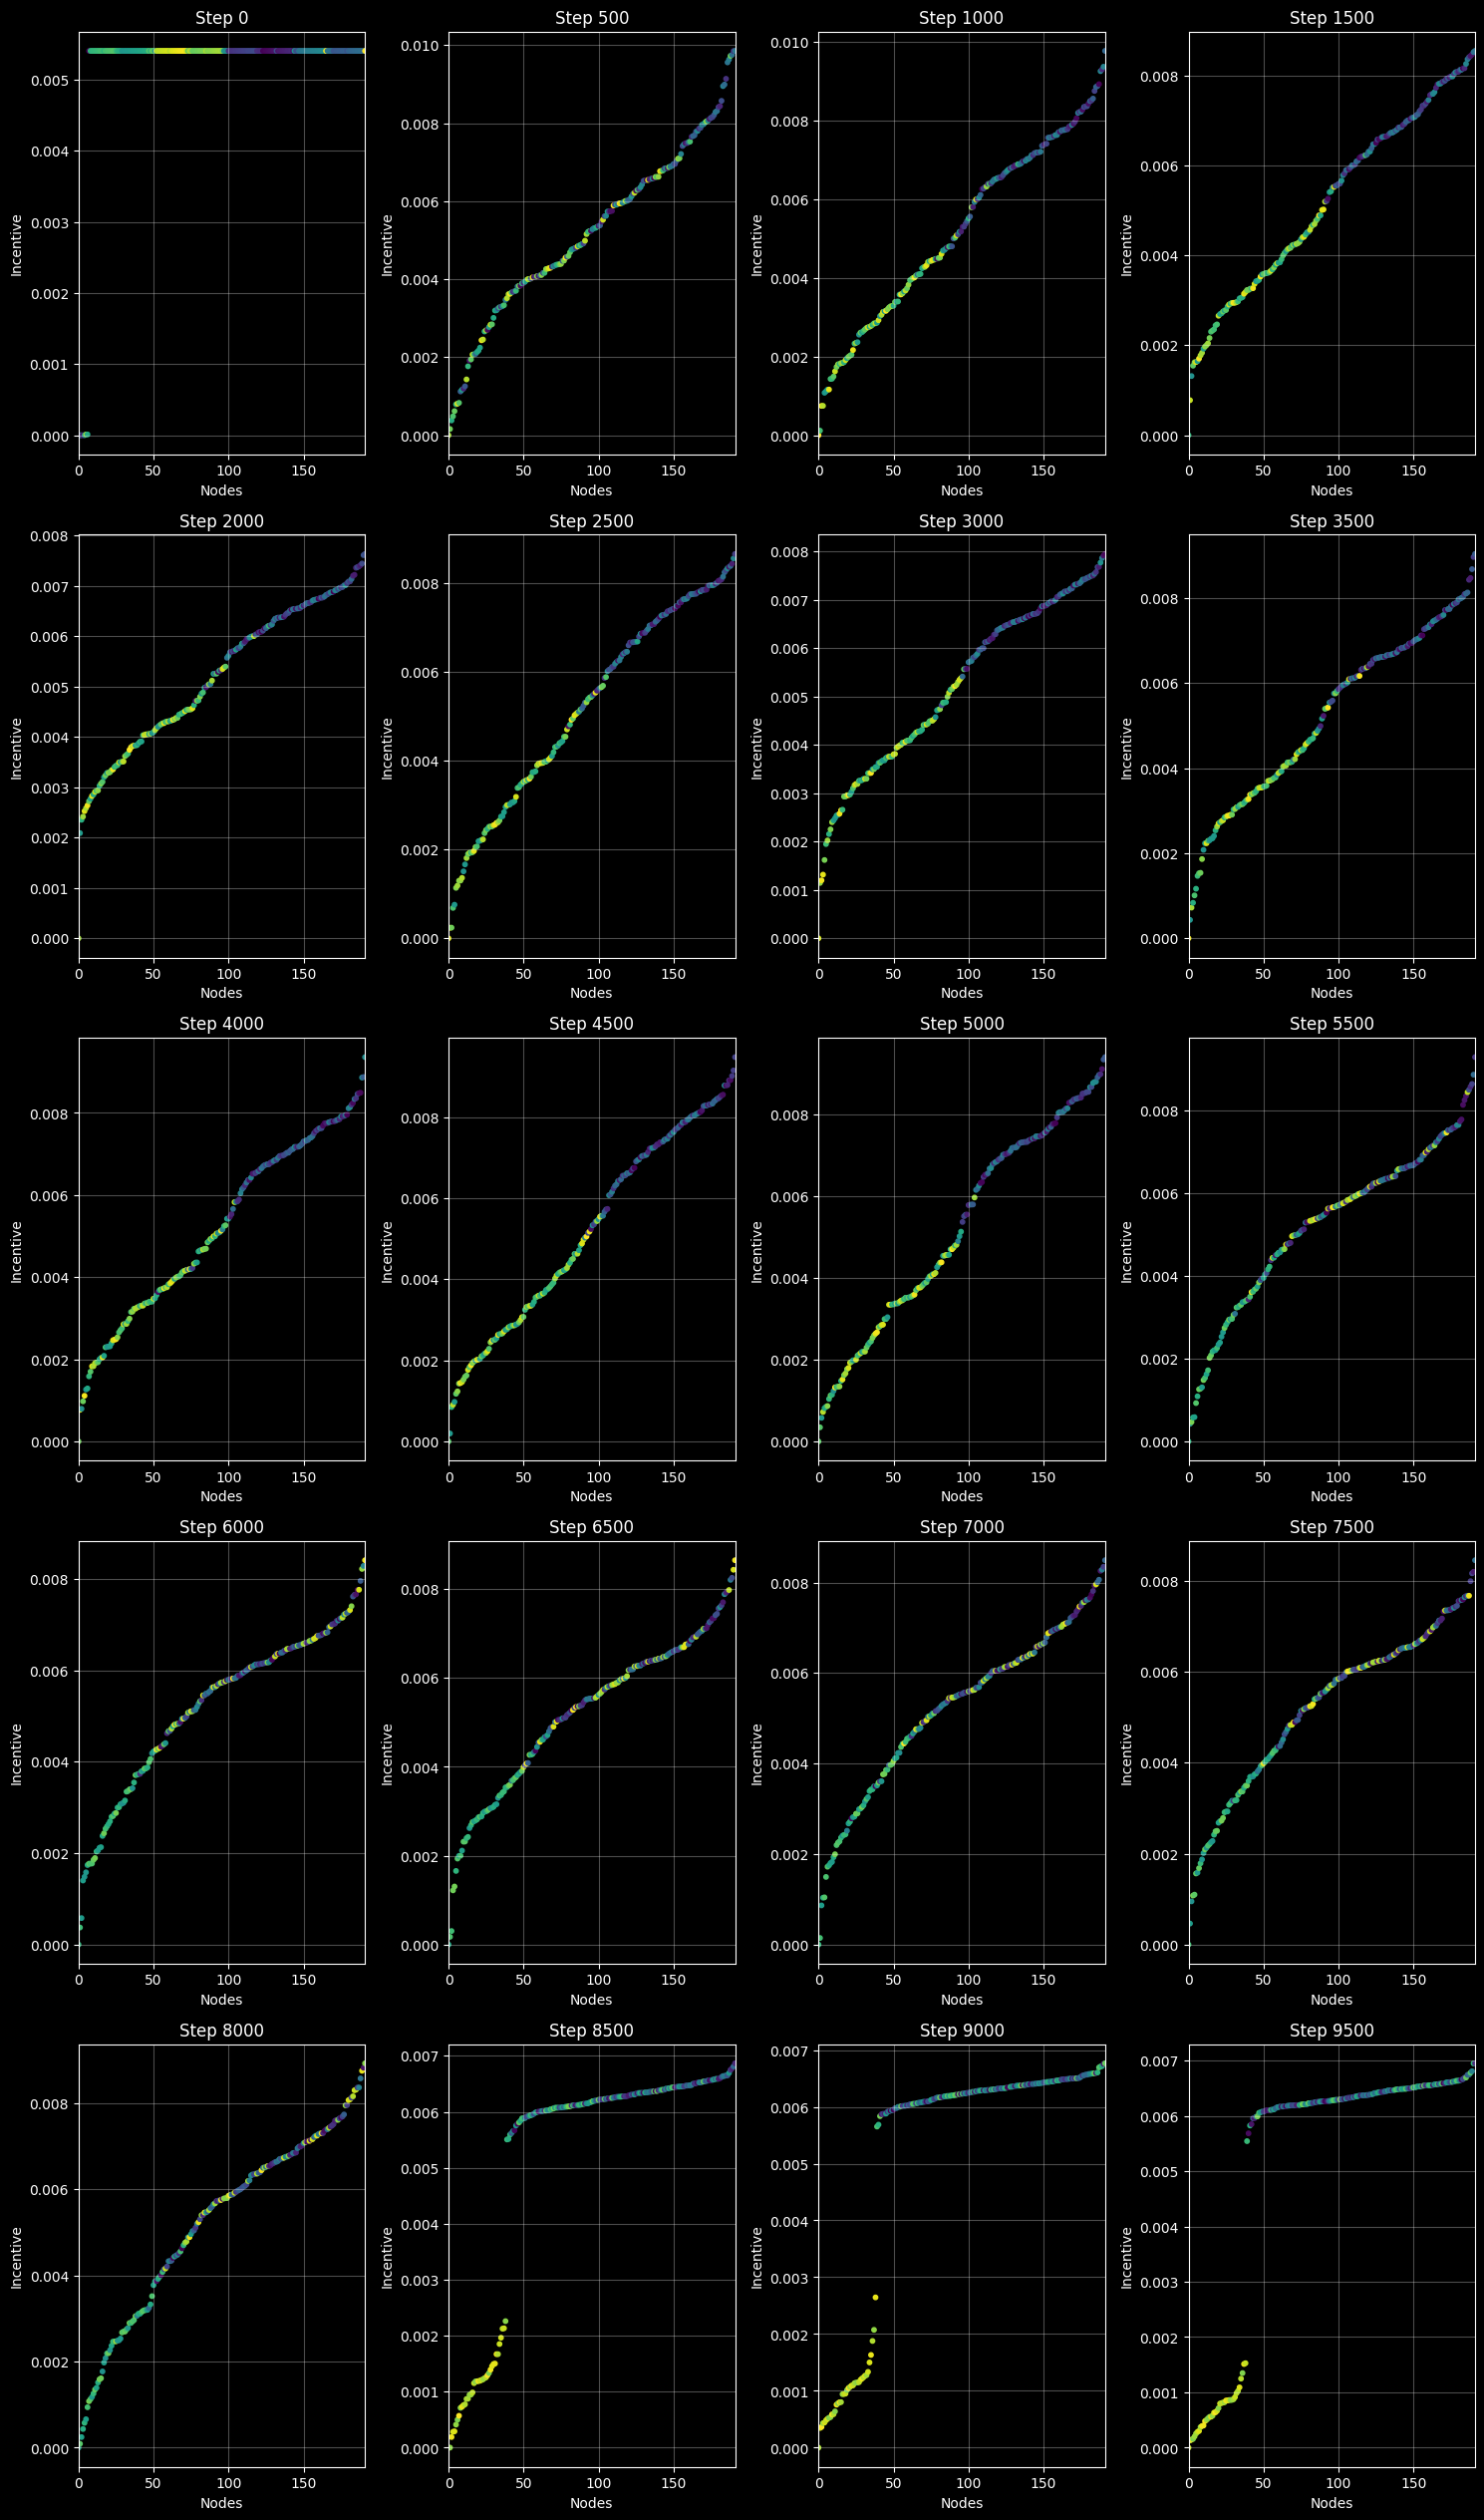

In [44]:

# Run simulations with 192 nodes
# Some of them will be reliable, some will fail, and some will degrade gradually
# Then plot the results
# In certain time intervals, the  repeutation score of the nodes will be plotted
# The y-axis for these charts will be the score of a node, each point on the chart will be a node, and they will be ordered in ascending order of their score along the x-axis
# Of course, since we are vieweing them over time, there will be multiple figures, one for each time interval
# Let's say we run the simulation for 10000 steps, and the scores of the nodes are plotted for every 2000 steps

def run_simulation_with_multiple_nodes():
    num_nodes = 192
    steps = 10000
    interval = 500
    
    # Initialize nodes with random initial reputations
    nodes = [NodeReputationSimulator() for _ in range(num_nodes)]
    uids = [f'node_{i}' for i in range(num_nodes)]
    
    # Calculate number of plots needed
    num_plots = steps // interval + 1
    # Calculate grid dimensions
    num_cols = 4
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    # Create a single figure for all plots
    fig = plt.figure(figsize=(15, 5*num_rows))
    
    # Simulate events for each node
    for step in range(steps):
        # some of them are very reliable, some are unreliable, and some degrade gradually
        if step < steps // 2: 
            for node in nodes[:num_nodes // 2]:
                node.apply_audit_result('success')
        elif step < steps * 0.8:
            for node in nodes[num_nodes // 2:int(num_nodes * 0.8)]:
                if np.random.random() < 0.1:
                    node.apply_audit_result('failure')
                else:
                    node.apply_audit_result('success')
        else:
            for node in nodes[int(num_nodes * 0.8):]:
                if np.random.random() < 0.05 + (step / steps) * 0.45:
                    node.apply_audit_result('failure')
                else:
                    node.apply_audit_result('success')
        
        for node in nodes:
            node.apply_audit_result('success' if np.random.random() < 0.95 else 'failure')
        
        # Plot every 'interval' steps
        if step % interval == 0:
            plot_index = step // interval + 1
            ax = fig.add_subplot(num_rows, num_cols, plot_index)
            
            scores = [node.history[-1]['audit_score'] for node in nodes]
            scores = [(score - min(scores)) / (max(scores) - min(scores)) for score in scores]
            l1_norm = np.sum(np.abs(np.array(scores)))
            epsilon = 1e-10
            incentives = [s / (l1_norm + epsilon) for s in scores]
            sorted_indices = np.argsort(scores)
            incentives.sort()
            
            scatter = ax.scatter(range(num_nodes), incentives, c=sorted_indices, cmap='viridis', s=10)
            ax.set_title(f'Step {step}')
            ax.set_xlim(0, num_nodes - 1)
            ax.set_xlabel('Nodes')
            ax.set_ylabel('Incentive')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

run_simulation_with_multiple_nodes()


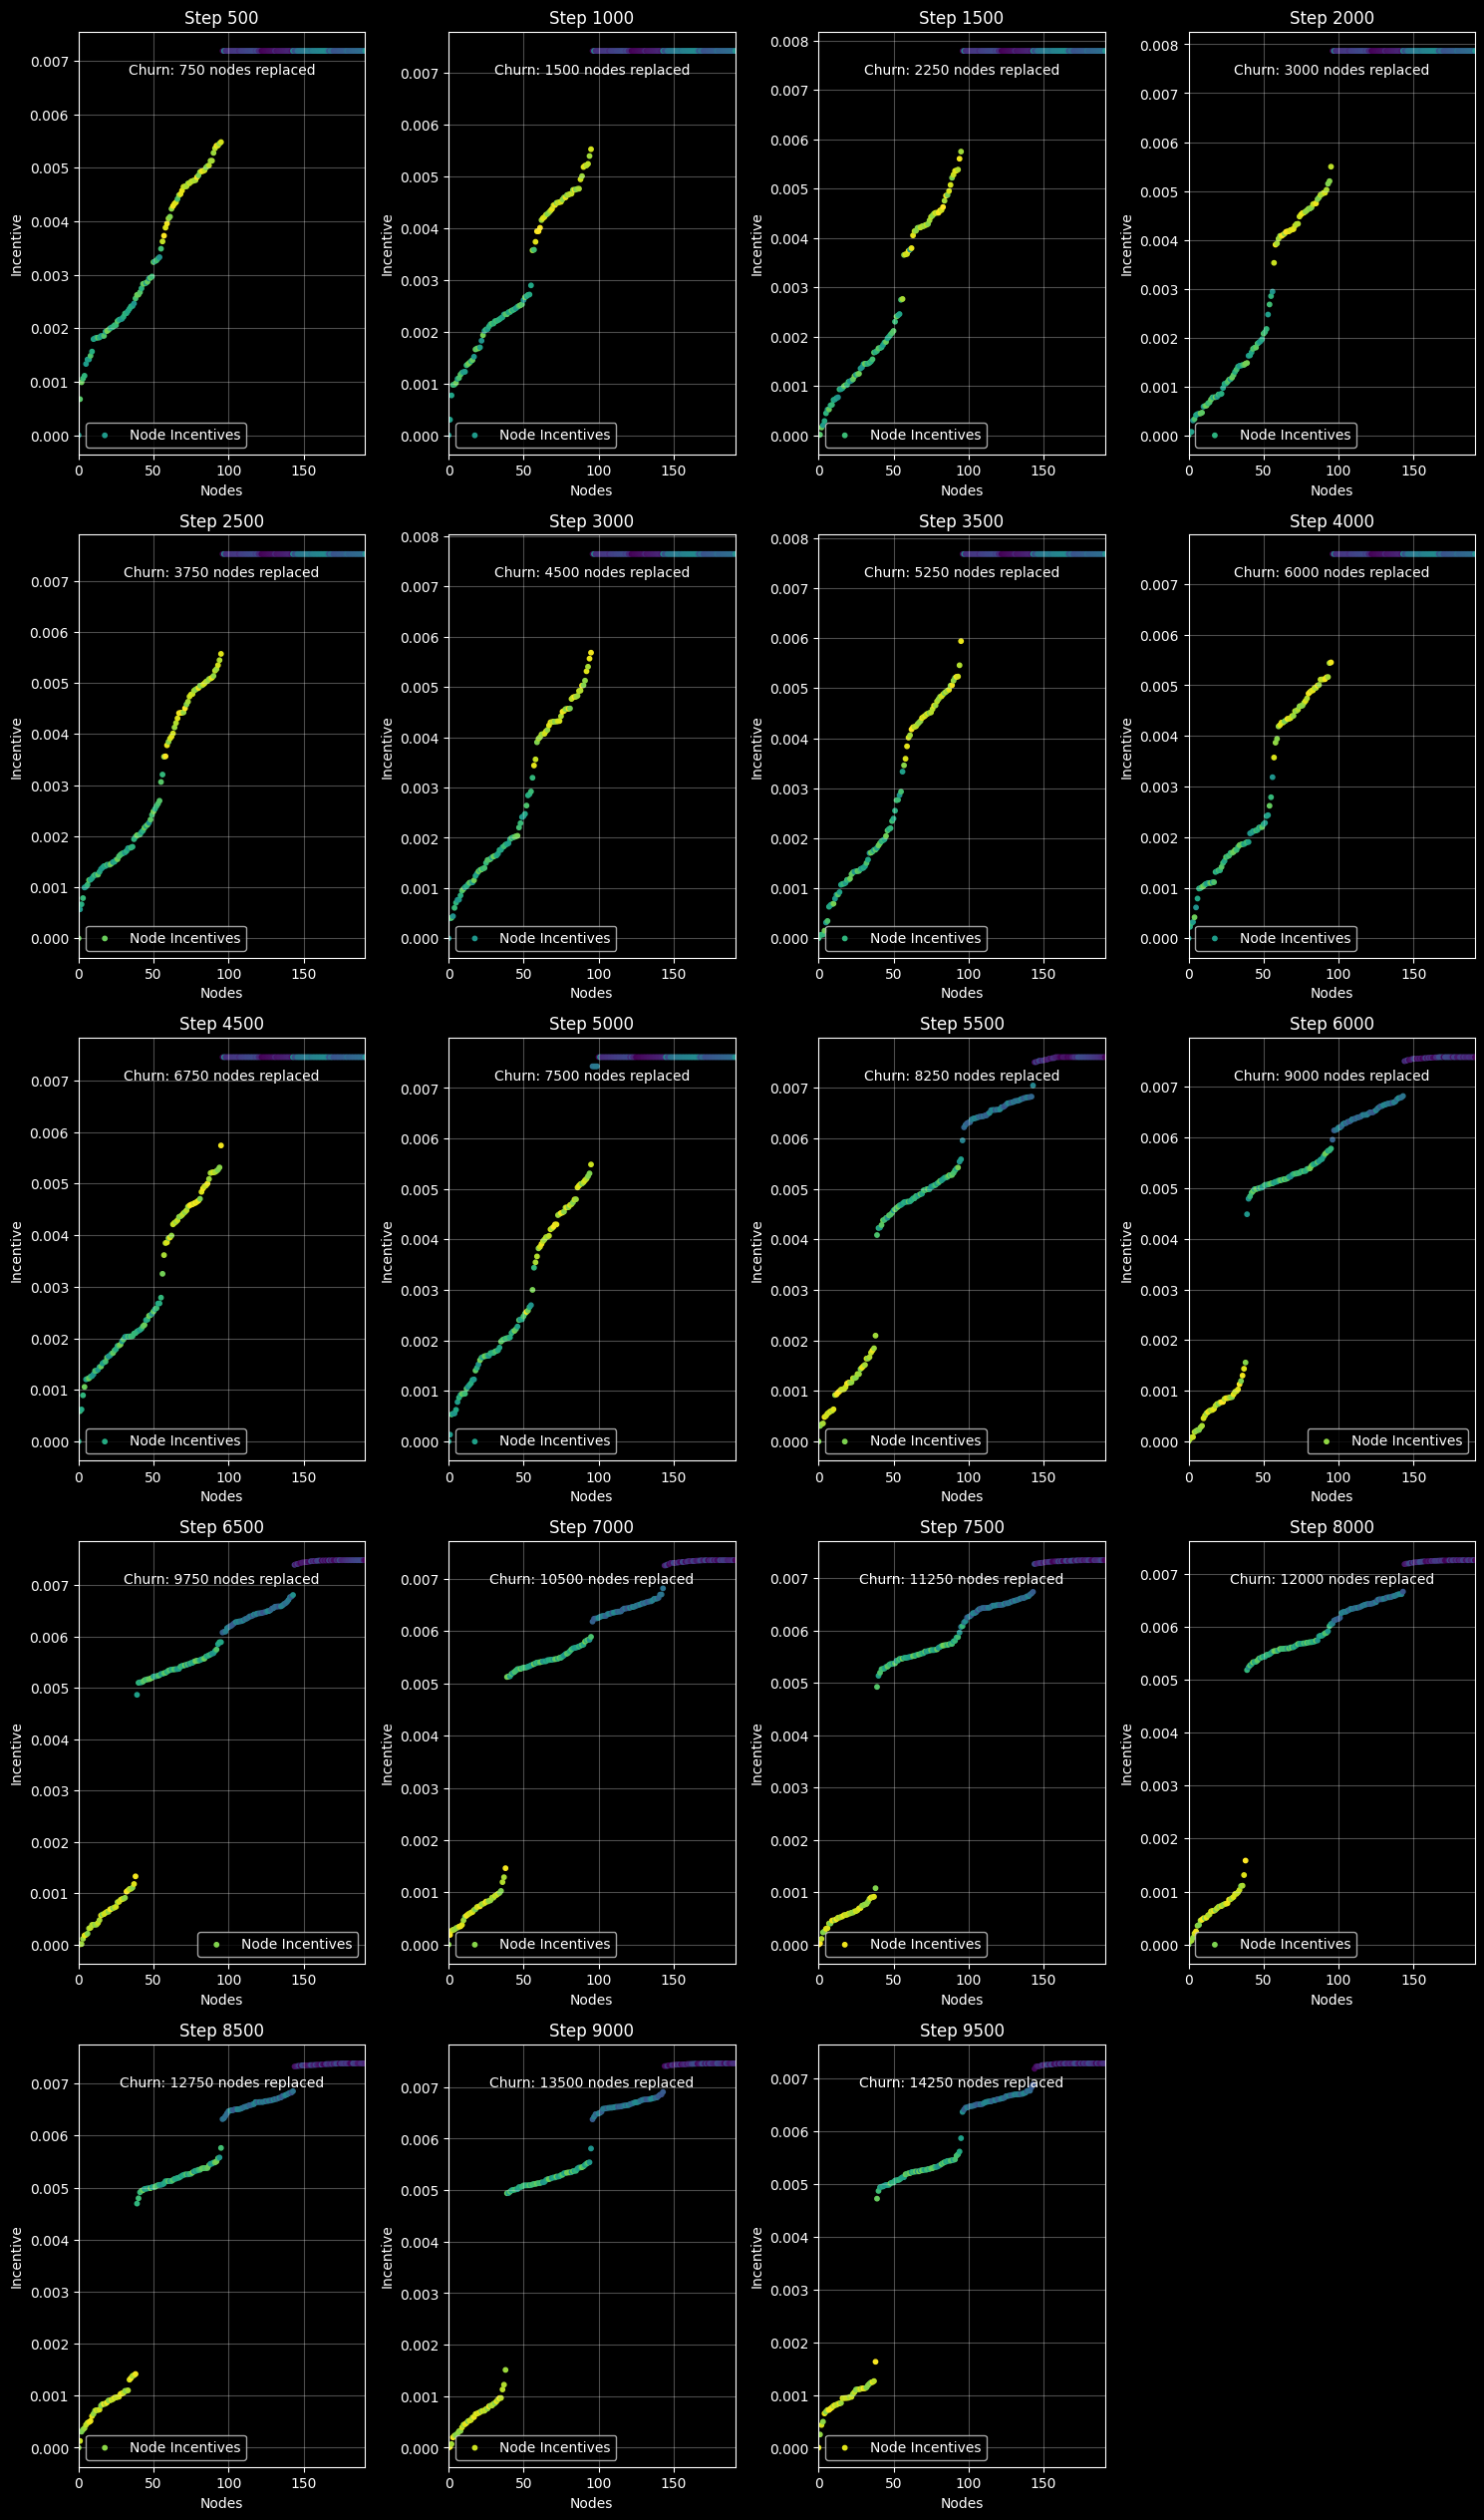

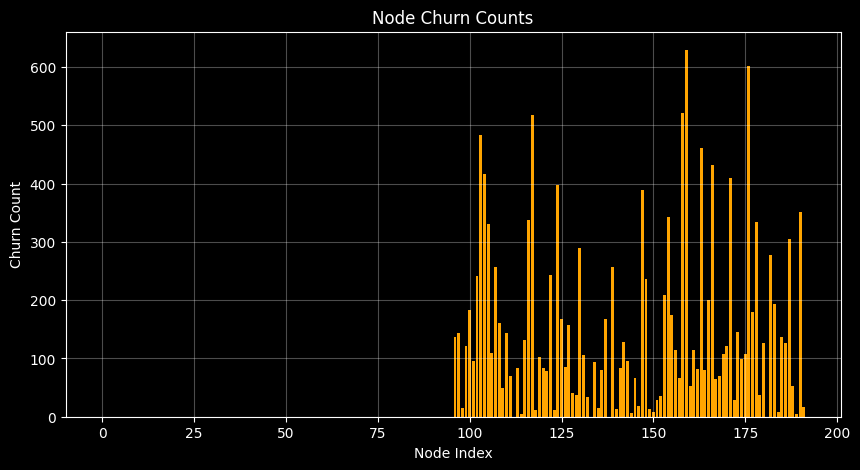

In [45]:
def run_simulation_with_node_churn():
    """Run a simulation with node churn, where nodes are replaced based on their reputation scores."""
    num_nodes = 192
    steps = 10000
    interval = 500
    
    # Initialize nodes with random initial reputations
    nodes = [NodeReputationSimulator() for _ in range(num_nodes)]
    uids = [f'node_{i}' for i in range(num_nodes)]
    
    # Calculate number of plots needed
    num_plots = steps // interval + 1
    # Calculate grid dimensions
    num_cols = 4
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    # Create a single figure for all plots
    fig = plt.figure(figsize=(15, 5*num_rows))
    
    # Track churn metrics
    churn_history = []
    
    for step in range(steps):
        # Apply audit results to ALL nodes each step
        for i, node in enumerate(nodes):
            # Different behavior for different node groups
            if i < num_nodes // 4:  # First quarter - very reliable nodes
                if step < steps // 2:
                    node.apply_audit_result('success')
                else:
                    # Even reliable nodes can occasionally fail
                    node.apply_audit_result('success' if np.random.random() < 0.999 else 'failure')
            elif i < num_nodes // 2:  # First half - reliable nodes
                if step < steps // 2:
                    node.apply_audit_result('success')
                else:
                    # Even reliable nodes can occasionally fail
                    node.apply_audit_result('success' if np.random.random() < 0.95 else 'failure')
            elif i < int(num_nodes * 0.8):  # Middle group - moderately unreliable
                if step < steps * 0.8:
                    if np.random.random() < 0.1:
                        node.apply_audit_result('failure')
                    else:
                        node.apply_audit_result('success')
                else:
                    node.apply_audit_result('success' if np.random.random() < 0.85 else 'failure')
            else:  # Last group - degrading nodes
                if step < steps // 2:
                    node.apply_audit_result('success' if np.random.random() < 0.95 else 'failure')
                else:
                    failure_rate = 0.05 + (step / steps) * 0.45
                    node.apply_audit_result('success' if np.random.random() > failure_rate else 'failure')
        
        # Node churn logic: every 360 steps, replace the lowest scoring node with a new one
        # Only apply churn after nodes have some history
        if step % 2 == 0 and step > 0:
            # Only consider nodes that have history
            nodes_with_history = [(i, node) for i, node in enumerate(nodes) if len(node.history) > 0]
            if nodes_with_history:
                # replace the 3 lowerst nodes with new nodes
                nodes_with_history.sort(key=lambda x: x[1].history[-1]['audit_score'])
                churn_indices = [index for index, _ in nodes_with_history[:3]]
                churn_history.extend(churn_indices)
        
        # Plot every 'interval' steps
        # Only plot after nodes have some history
        if step % interval == 0 and step > 0:
            plot_index = step // interval
            ax = fig.add_subplot(num_rows, num_cols, plot_index)
            
            # Only include nodes with history
            nodes_with_history = [node for node in nodes if len(node.history) > 0]
            if nodes_with_history:
                scores = [node.history[-1]['audit_score'] for node in nodes_with_history]
                if len(set(scores)) > 1:  # Avoid division by zero
                    scores = [(score - min(scores)) / (max(scores) - min(scores)) for score in scores]
                    l1_norm = np.sum(np.abs(np.array(scores)))
                    epsilon = 1e-10
                    incentives = [s / (l1_norm + epsilon) for s in scores]
                    sorted_indices = np.argsort(scores)
                    incentives.sort()
                    scatter = ax.scatter(range(len(nodes_with_history)), incentives, c=sorted_indices, cmap='viridis', s=10)
                else:
                    # All scores are the same
                    incentives = [1.0/len(scores)] * len(scores)
                    scatter = ax.scatter(range(len(nodes_with_history)), incentives, c='blue', s=10)
                
                ax.set_title(f'Step {step}')
                ax.set_xlim(0, len(nodes_with_history) - 1)
                ax.set_xlabel('Nodes')
                ax.set_ylabel('Incentive')
                ax.grid(True, alpha=0.3)
                ax.legend([scatter], ['Node Incentives'])
                ax.text(0.5, 0.9, f'Churn: {len(churn_history)} nodes replaced', 
                        transform=ax.transAxes, ha='center', fontsize=10, color='white')
    plt.tight_layout()
    plt.show()

    # also plot the number of times a node was replaced (by their sorted index of score)
    churn_counts = np.zeros(num_nodes)
    for index in churn_history:
        churn_counts[index] += 1
    plt.figure(figsize=(10, 5))
    plt.bar(range(num_nodes), churn_counts, color='orange')
    plt.title('Node Churn Counts')
    plt.xlabel('Node Index')
    plt.ylabel('Churn Count')
    plt.grid(True, alpha=0.3)

run_simulation_with_node_churn()